useful links:

- Data Preparation for Variable Length Input Sequences, URL: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
- Masking and padding with Keras, URL: https://www.tensorflow.org/guide/keras/masking_and_padding
- Step-by-step understanding LSTM Autoencoder layers, URL: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352XX, 
- Understanding input_shape parameter in LSTM with Keras, URL: https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
- tf.convert_to_tensor, URL: https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
- ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python, URL: https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type

In [683]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import re
import random
import json
import csv
from datetime import datetime
from collections import OrderedDict
from collections import Counter
from collections import deque

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt

# natural language processing packages
import gensim
from gensim import models
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# downloading nlkt data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sample handling sklearn package
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

# # Keras + Tensorflow ML libraries
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D

# ===============================
# developed python libraries
# ===============================

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [684]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [685]:
# variable definitions
# root folder
dataf = "Data"

# subfolder with the OCR transcrived txt data
targetf = "Target"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Std"

# dataframe file extension
fext = "csv"

# dictionary extension
dext = "dict"

# dataframe file name
small_fn = "std-VVG-Gallery-Text-Data-Small" + "." + fext
large_fn = "std-VVG-Gallery-Text-Data-Large" + "." + fext

# dictionary file name
sdict_fn = "VVG-Gallery-Text-Data-Small" + "." + dext
ldict_fn = "VVG-Gallery-Text-Data-Large" + "." + dext

# ramdom seed
randseed = 42

# window size
min_wsize = 20
max_wsize = 30
def_wsize = int((min_wsize+max_wsize)/2)

# sample distribution train vs test sample size
trainf = 0.80
testf = 0.20

# regex to know that column Im interested in
keeper_regex = r"(^ID$)|(^STD_)"

# default values
work_fn = small_fn
work_dict = sdict_fn
# work_fn = large_fn
# work_dict = ldict_fn

In [686]:
# variable reading
# dataframe filepath
fn_path = os.path.join(os.getcwd(), dataf, stdf, work_fn)
print(fn_path)

# gensim dictionart filepath
dict_path = os.path.join(os.getcwd(), dataf, stdf, work_dict)
print(dict_path)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-LSTM-TextAutoencoder\Data\Std\std-VVG-Gallery-Text-Data-Small.csv
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-LSTM-TextAutoencoder\Data\Std\VVG-Gallery-Text-Data-Small.dict


In [687]:
# reading words dictionary
# loading gesim words dictionary
vvg_dict = gensim.corpora.Dictionary()
vvg_dict = vvg_dict.load(dict_path)
print(vvg_dict)

Dictionary(660 unique tokens: ['1', '11', '16', '1853', '1885']...)


In [688]:
# rading training data
# loading file
source_df = pd.read_csv(
                fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )

In [689]:
# checking everything is allrigth
source_df.head(5)
# chekcing the dataframe
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 56 columns):
 #   Column                                                                                              Non-Null Count  Dtype 
---  ------                                                                                              --------------  ----- 
 0   ID                                                                                                  59 non-null     object
 1   CORE_TEXT                                                                                           59 non-null     object
 2   EXT_TEXT                                                                                            59 non-null     object
 3   complementary colours                                                                               59 non-null     object
 4   this torso of Venus                                                                                 59 non-null     object
 

In [690]:
# selecting data to train
# want to keep the columns starting with STD_
df_columns = list(source_df)
print("------ original input/interested columns ------")
print(df_columns)

# create the columns Im interesting in
keep_columns = [i for i in df_columns if re.search(keeper_regex, i)]

print("\n\n------ Interesting columns ------")
print(keep_columns)


------ original input/interested columns ------
['ID', 'CORE_TEXT', 'EXT_TEXT', 'complementary colours', 'this torso of Venus', 'drew', 'Van Gogh wrote', 'standing torso of Venus', 'he wrote', 'The Potato Eaters', 'which he painted a number of times', 'He would use this technique more than once in his later work', 'Head of a Woman', 'Head of a Man', 'Head of a Woman 1', 'Head of a Woman 2', 'Head of a Woman 3', 'Torso of Venus', 'Horse', 'Torso of Venus 1', 'Male Torso', 'Kneeling Ecorche', 'Torso of Venus 2', 'Portrait of a Prostitute', 'Head of an Old Man', 'Head of a Woman 4', 'Plaster Cast of a Womans Torso', 'Plaster Cast of a Womans Torso 1', 'Torso of Venus 3', 'Woman Sewing', 'Letter from Vincent van Gogh to Theo van Gogh with sketches of Head of a Woman and Head of a Woman', 'Head of a Prostitute', '1885', 'Nuenen', 'painting', 'heads', 'Antwerp', 'portrait', '1886', 'Paris', 'still life', 'nude', '1884', '1887', 'animal art', 'drawing', '1890', 'cityscape', '1881', 'Brussels'

In [691]:
# creating the training dataframe
train_df = pd.DataFrame(source_df, columns=keep_columns)

In [692]:
# getting the column with the relevant data to train
dvector_col = [i for i in df_columns if re.search(u"^STD_", i)]
dvector_col = dvector_col[0]
print("Dense vector column in dataframe: ", str(dvector_col))

Dense vector column in dataframe:  STD_DVEC_TOKENS


In [693]:
# fix column data type
work_corpus = train_df[dvector_col]
dvec_std_corpus = list()

for dvector in work_corpus:
    dvector = eval(dvector)
    dvector = np.array(dvector)
    dvec_std_corpus.append(dvector)

dvec_std_corpus = np.array(dvec_std_corpus, dtype="object")

In [694]:
# changing type in dataframe
train_df[dvector_col] = dvec_std_corpus

In [695]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               59 non-null     object
 1   STD_DVEC_TOKENS  59 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB


In [696]:
# padding training data according to max length of text corpus
pad_prefix = "PAD_"
recurrent_prefix = "LSTM_"
padded_corpus = None

# getting the corpus dense vectors
dvec_std_corpus = train_df[dvector_col]

# converting list of list to array of array
# npdvec_std_corpus = np.array([np.array(x, dtype="object") for x in dvec_std_corpus], dtype="object")
# dvec_std_corpus = np.array(dvec_std_corpus, dtype="object")
print(dvec_std_corpus.shape)

# padding the representation
padded_corpus = pad_sequences(dvec_std_corpus, dtype='object', padding="post")
print(padded_corpus.shape)

# creating the new column and saving padded data
padded_col = pad_prefix + dvector_col
# print(padded_col)
train_df[padded_col] = list(padded_corpus)
print(padded_corpus.shape)

(59,)
(59, 140)
(59, 140)


In [697]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   59 non-null     object
 1   STD_DVEC_TOKENS      59 non-null     object
 2   PAD_STD_DVEC_TOKENS  59 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


In [698]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
X = np.array([np.array(i, dtype="object") for i in train_df[padded_col]], dtype="object")
y = np.array([np.array(j, dtype="object") for j in train_df[padded_col]], dtype="object")

# X = train_df[padded_col]
# y = train_df[padded_col]

print(X.shape)
print(y.shape)

(59, 140)
(59, 140)


In [699]:
print(type(X[0]))
print(type(X[0][0]))
print(X.shape)

<class 'numpy.ndarray'>
<class 'float'>
(59, 140)


In [700]:
print(type(y[0]))
print(type(y[0][0]))
print(y.shape)

<class 'numpy.ndarray'>
<class 'float'>
(59, 140)


In [701]:
# timestep is the memory of what i read, this is the longest sentence I can remember in the short term
# neet to look for the best option, in small the max is 15
timesteps = 15

# features is the max length in the corpus, after padding!!!!
features = X.shape[1]
print(timesteps, features)

15 140


In [702]:
# preparation for reshape lstm model
Xt = temporalize(X, timesteps)
yt = temporalize(y, timesteps)

In [703]:
# reshaping for LSTM model
X_lstm = Xt.reshape((Xt.shape[0], timesteps, features))
y_lstm = yt.reshape((yt.shape[0], timesteps, features))
print(X_lstm.shape)
print(y_lstm.shape)
# X_train = train_inputs.reshape((split,3,2))
# X_test = X_test.reshape((test_inputs.shape[0], 3, 2))

(43, 15, 140)
(43, 15, 140)


In [704]:
# creating the column for the reshape data according to LSTM
lstm_col = recurrent_prefix + dvector_col
print(lstm_col)
# lstm_df
# train_df[lstm_col] = list(X_lstm)

LSTM_STD_DVEC_TOKENS


In [705]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   59 non-null     object
 1   STD_DVEC_TOKENS      59 non-null     object
 2   PAD_STD_DVEC_TOKENS  59 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


In [706]:
# data to numpy format
X_lstm = np.asarray(X_lstm).astype(np.float)
# y_lstm = np.asarray(y_lstm).astype(np.float)
print(X_lstm.shape)
# print(y_lstm.shape)
# y = y.to_numpy()

(43, 15, 140)


In [707]:
# dividing according to train/test proportions
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, train_size = trainf, test_size = testf, random_state = randseed)

In [708]:
# checking shaped
print("training shape (X, y)")
print("X: ", X_train.shape, " y: ", y_train.shape)

print("testing shape (X, y)")
print("X: ", X_test.shape, " y: ", y_test.shape)

print("data types")
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train[0]), type(X_test[0]), type(y_train[0]), type(y_test[0]))
print(type(X_train[0][0]), type(X_test[0][0]), type(y_train[0][0]), type(y_test[0][0]))
print(type(X_train[0][0][0]), type(X_test[0][0][0]), type(y_train[0][0][0]), type(y_test[0][0][0]))

training shape (X, y)
X:  (34, 15, 140)  y:  (34, 15, 140)
testing shape (X, y)
X:  (9, 15, 140)  y:  (9, 15, 140)
data types
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'float'> <class 'float'>


In [709]:
Xtf_train = tf.convert_to_tensor(X_train, dtype="float64")
Xtf_test = tf.convert_to_tensor(X_test, dtype="float64")
ytf_train = tf.convert_to_tensor(y_train, dtype="float64")
ytf_test = tf.convert_to_tensor(y_test, dtype="float64")

# y_tensor = tf.convert_to_tensor(y, dtype=tf.float23) 

In [710]:
# number of neurons or processing units in LSTM
# the number is because of good practices for NLP
# min 200 max 500, normaly 300 (related to the semantic number of themes)
# 120 for now in this test
lstm_units = 200

# timestep is 1 because you read a word at a time
memory = timesteps
print("--- LSTM memory span ---")
print(memory)

# features is the max length in the corpus, after padding!!!!
features = X_train.shape[2]
print("--- LSTM learning features ---")
print(features)

# batch size
sample_size = int(X_train.shape[0]*0.1)
print("--- LSTM learning batch size ---")
print(sample_size)

print("--- LSMT processing units ---")
print(lstm_units)

# configuration to remember previous recurrent layer
retSeq = True

# neurons/processing units size in the dense layer (THIS SHOULD BE SOM!!!!)
dn1 = 32*32
print("--- Dense processing units ---")
print(dn1)
# dn2 = len(XB_set[0])*SECURITY_FACTOR

# numero de neuronas de salida
outn1 = X_train.shape[2]
print("--- Output prediction units ---")
print(outn1)

# axtivation functions
inn = "relu"
act = "relu"
out = "softmax"

# loss percentage
ldrop = 0.2

# random seed
randseed = 42

# parameters to compile model
# loss function
ls = "mean_squared_error"
# doptimization function
opti = "adam"
# evaluation score
met = ["accuracy"]

# parameters to exeute training
# verbose mode
ver = 1
# training epocha
epo = 300
# batch size
bs = 1 #y.shape[1]


# checking values
print(lstm_units, memory, features)

--- LSTM memory span ---
15
--- LSTM learning features ---
140
--- LSTM learning batch size ---
3
--- LSMT processing units ---
200
--- Dense processing units ---
1024
--- Output prediction units ---
140
200 15 140


In [711]:
# model layers
# to avoid overfit you need to use dropout in someplaces
lstm_layers = (

    # input layer (padding and prep)
    # Masking(mask_value=0.0, input_shape=(memory, features)),
    # first recurrent encoder layer
    LSTM(lstm_units, activation=inn, input_shape=(memory, features), return_sequences=True),
    Dropout(ldrop, seed=randseed),

    # # second recurrent encoder layer
    LSTM(int(lstm_units/2), activation=inn, input_shape=(timesteps, features), return_sequences=True),
    Dropout(ldrop, seed=randseed),

    # # dense layer for abstraction (THIS SHOULD BE SOM!!!!)
    Dense(dn1, activation=act),

    # # first recurrent decoder layer
    Dropout(ldrop, seed=randseed),
    LSTM(int(lstm_units/2), activation=inn, input_shape=(timesteps, features), return_sequences=True),

    # # second recurrent decoder layer
    Dropout(ldrop, seed=randseed),
    LSTM(lstm_units, activation=inn, input_shape=(timesteps, features), return_sequences=True),

    # output layer, dense time sequential layer.
    TimeDistributed(Dense(outn1, activation=out)),
)

In [712]:
# defining model
lstm_model = Sequential(lstm_layers)

In [713]:
# compile model
lstm_model.compile(loss = ls, optimizer = opti, metrics = met)
lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 15, 200)           272800    
_________________________________________________________________
dropout (Dropout)            (None, 15, 200)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 15, 100)           120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 15, 1024)          103424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 1024)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 15, 100)         

In [714]:
# early stopping condition BECAAUSE THIS ARE TESTS
EarlyStopLSTM_Acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0, patience = 30, verbose = 1, mode = "max", restore_best_weights = True)


In [715]:
# training model
history_lstm = lstm_model.fit(
    x = Xtf_train, 
    y = ytf_train,
    epochs = epo, 
    verbose = ver, 
    workers = 4,
    batch_size = bs, 
    callbacks = [EarlyStopLSTM_Acc],
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (Xtf_test, ytf_test),
)

Epoch 1/300
34/34 [==============================] - 4s 36ms/step - loss: 0.0083 - accuracy: 0.0718 - val_loss: 0.0077 - val_accuracy: 0.1630
Epoch 2/300
34/34 [==============================] - 1s 21ms/step - loss: 0.0081 - accuracy: 0.1125 - val_loss: 0.0066 - val_accuracy: 0.1630
Epoch 3/300
34/34 [==============================] - 1s 21ms/step - loss: 0.0072 - accuracy: 0.0768 - val_loss: 0.0063 - val_accuracy: 0.1630
Epoch 4/300
34/34 [==============================] - 1s 21ms/step - loss: 0.0069 - accuracy: 0.1056 - val_loss: 0.0061 - val_accuracy: 0.1037
Epoch 5/300
34/34 [==============================] - 1s 22ms/step - loss: 0.0068 - accuracy: 0.1009 - val_loss: 0.0060 - val_accuracy: 0.0889
Epoch 6/300
34/34 [==============================] - 1s 22ms/step - loss: 0.0067 - accuracy: 0.1073 - val_loss: 0.0059 - val_accuracy: 0.0963
Epoch 7/300
34/34 [==============================] - 1s 21ms/step - loss: 0.0067 - accuracy: 0.1253 - val_loss: 0.0058 - val_accuracy: 0.1333
Epoch 

In [716]:
# saving model

In [717]:
# testing model
lstm_results = lstm_model.predict(X_test)#, batch_size = bs)#, verbose = 1)#, batch_size = bs)

In [718]:
# just checking
lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 15, 200)           272800    
_________________________________________________________________
dropout (Dropout)            (None, 15, 200)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 15, 100)           120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 15, 1024)          103424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 1024)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 15, 100)         

In [719]:
# cheking test shape
print(lstm_results.shape)

(9, 15, 140)


<ipython-input-720-3ce915c3119e>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


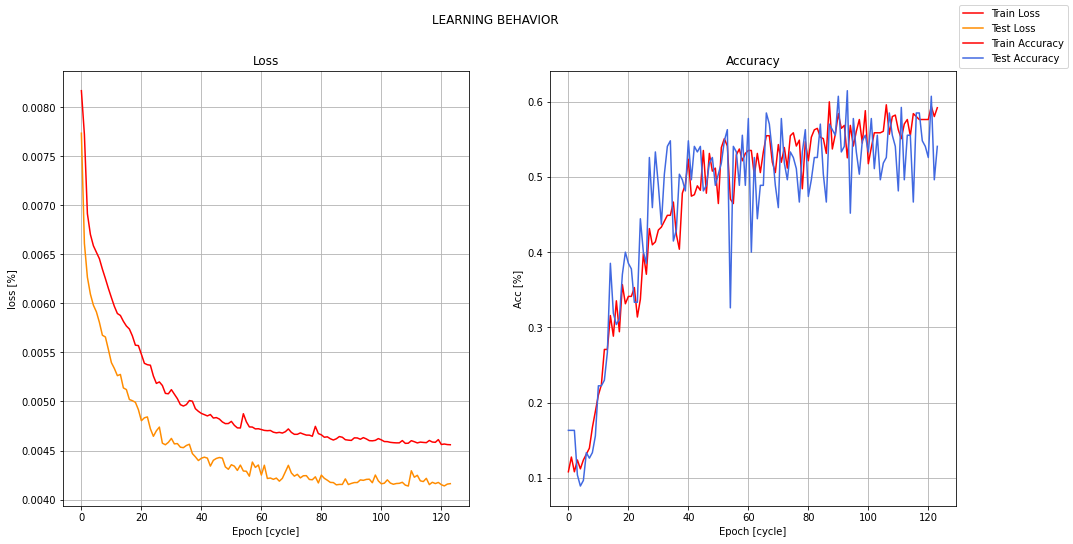

In [720]:
# reporting results
# reporte de entrenamiento para el modelo
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# datos de la figura en de perdida y precision
ax1.plot(history_lstm.history["loss"], 'red', label = "Train Loss")
ax1.plot(history_lstm.history["val_loss"], 'darkorange', label = "Test Loss")
ax2.plot(history_lstm.history["accuracy"], 'red', label = "Train Accuracy")
ax2.plot(history_lstm.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [721]:
lstm_test_text = """
                There is a khan's daughter
                Who steps on in a SWINGING manner
                And has the marks of twenty tigers,
                Who steps on in a GRACEFUL manner
                And has the marks of thirty manner
                Who steps on in an ELEGANT manner
                And has the marks of forty tigers,
                Who steps on in a DELICATE manner
                And has the marks of fifty tigers.
                """
print(lstm_test_text)


                There is a khan's daughter
                Who steps on in a SWINGING manner
                And has the marks of twenty tigers,
                Who steps on in a GRACEFUL manner
                And has the marks of thirty manner
                Who steps on in an ELEGANT manner
                And has the marks of forty tigers,
                Who steps on in a DELICATE manner
                And has the marks of fifty tigers.
                
